In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
BASE_PATH = '../../Dataset/same length/'

In [2]:
def generateModel(input_shape, lr=0.001):
    print("Generatin Model...")
    model = keras.models.Sequential()
    # first layer
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=input_shape,
                                  kernel_regularizer=keras.regularizers.l2(0.001), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    # 2 con layer
    model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    # 3 conv
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001), padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    #flatten layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(4, activation="softmax"))
    ## compile
    optimizer = keras.optimizers.Adam(lr)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

# Getting the trainig and Testing Data

In [3]:
# json files
mfcc24 = BASE_PATH+"mfcc24_sl.json"
mfcc48 = BASE_PATH+"mfcc48_sl.json"
mfcc13 = BASE_PATH+"mfcc13_sl.json"
mel = BASE_PATH+"mel.json"

In [4]:
def get_train_and_test(json_file_name, test_size, val_size):
    le = LabelEncoder()
    # laod the data
    with open(json_file_name, 'r') as file:
        data_loaded = json.load(file)
    #split the data
    X, y = np.array(data_loaded["features"]), np.array(data_loaded["labels"])
    # X = X[..., np.newaxis]
    print(X.shape)
    print(y.shape)
    # add new axis to the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=123)
    # #use label encoder
    # x_train = x_train[..., np.newaxis]
    # print(x_train[0].shape)
    # print(y_train.shape)
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    y_val = le.transform(y_val)
    class_names = np.unique(le.inverse_transform(y_train))
    # return the splited data
    return x_train, x_test, x_val, y_train, y_test, y_val, class_names

In [5]:
def get_splitted_data(json_file_name):
    test_size = 0.2
    val_size = 0.1
    # get_train_and_test(json_file_name, test_size, val_size)
    xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_train_and_test(json_file_name, test_size, val_size)
    return xtrain, xtest, xval, ytrain, ytest, yval, class_names


def trainModel(xtrain, xtest, xval, ytrain, ytest, yval,epochs=30, modelName="1"):
    print("Trying To Train the Model...")
    lr = 0.001
    input_shape = xtrain[0].shape
    print(input_shape)
    model = generateModel(input_shape, lr)
    history = model.fit(xtrain, ytrain, batch_size=32, epochs=epochs, validation_data=(xval, yval))
    testError, testAcc = model.evaluate(xtest, ytest)
    print(f"Test error: {testError}, Test acc: {testAcc}")
    # modelName = jsonFileName.split(".")[0]
    model.save(f"{modelName}.h5")
    return history
    # return None

In [6]:
import matplotlib.pyplot as plt
def plotHistory(hist):
    fig, axs = plt.subplots(2)
    # accuracy of
    axs[0].plot(hist.history['accuracy'], "g", label="Train Accuracy")
    axs[0].plot(hist.history['val_accuracy'], "b", label="Validation Accuracy")
    axs[0].set_title('Model Accuracies')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')
    # summarize history for loss
    axs[1].plot(hist.history['loss'], 'r', label="Train Loss")
    axs[1].plot(hist.history['val_loss'], 'b', label="Val Loss")
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='lower right')
    plt.show()

In [7]:
def plot_conf_matrix(predictions, ytest, labels):
    conf_mat = confusion_matrix(predictions, ytest)
    plot_confusion_matrix(conf_mat, show_normed=True, class_names=labels)

In [8]:
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc13)
mfcc13_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 13")

(705, 13, 216, 1)
(705,)
Trying To Train the Model...
(13, 216, 1)
Generatin Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 216, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 216, 64)       256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 108, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 108, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 108, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 54, 32)         0         
____________________________________

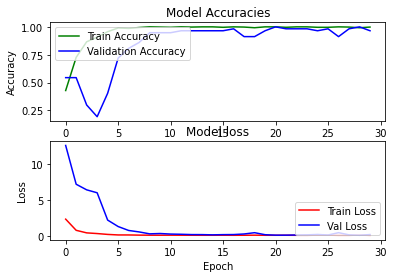

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


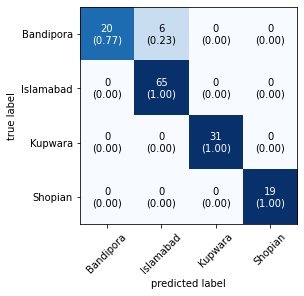

In [9]:
plotHistory(mfcc13_history)
model13 = keras.models.load_model("./Mfcc 13.h5")
predictions = model13.predict_classes(xtest)
plot_conf_matrix(predictions, ytest, class_names)

In [15]:
# mfcc 24 model training
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc24)
mfcc23_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 24")

(705, 24, 216, 1)
(705,)
Trying To Train the Model...
(24, 216, 1)
Generatin Model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 216, 64)       640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 216, 64)       256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 108, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 108, 32)       18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 108, 32)       128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 54, 32)         0         
__________________________________

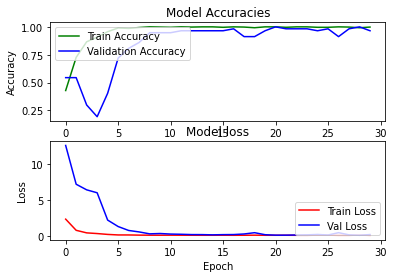

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


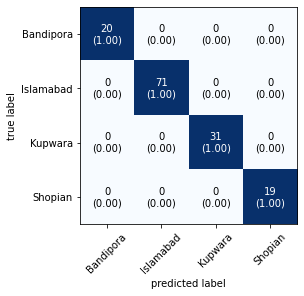

In [16]:
plotHistory(mfcc13_history)
model24 = keras.models.load_model("./Mfcc 24.h5")
predictions = model24.predict_classes(xtest)
plot_conf_matrix(predictions, ytest, class_names)

In [12]:
# mfcc 48 model training
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc48)
mfcc48_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 48")

(705, 48, 216, 1)
(705,)
Trying To Train the Model...
(48, 216, 1)
Generatin Model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 216, 64)       640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 216, 64)       256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 108, 64)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 108, 32)       18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 108, 32)       128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 54, 32)        0         
__________________________________

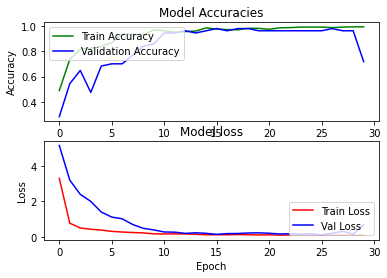

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


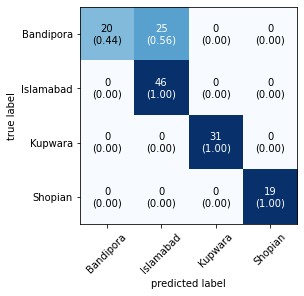

In [14]:
plotHistory(mfcc48_history)
model48 = keras.models.load_model("./Mfcc 48.h5")
predictions = model48.predict_classes(xtest)
plot_conf_matrix(predictions, ytest, class_names)

(705, 128, 216, 1)
(705,)
Trying To Train the Model...
(128, 216, 1)
Generatin Model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 216, 64)      640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 216, 64)      256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 108, 64)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 108, 32)       18464     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 108, 32)       128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 54, 32)        0         
________________________________

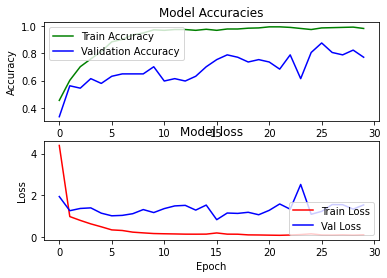

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


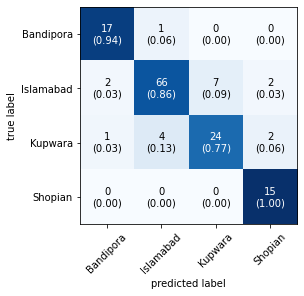

In [17]:
#Mel
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mel)
mel_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="mel")
plotHistory(mel_history)
model48 = keras.models.load_model("./mel.h5")
predictions = model48.predict_classes(xtest)
plot_conf_matrix(predictions, ytest, class_names)

In [23]:
#### rough
for i, pred in enumerate(predictions):
    print(predictions[i], ytest[i])

2 2
3 3
1 1
2 2
0 1
3 3
3 3
0 0
3 3
1 1
1 1
1 1
2 2
1 1
2 2
1 1
1 1
2 2
3 3
1 1
1 1
1 1
1 1
1 1
0 1
0 1
2 2
1 1
0 0
0 0
1 1
1 1
1 3
2 2
2 2
2 2
0 1
2 2
3 3
1 1
2 2
1 1
1 1
3 3
2 2
2 2
2 2
1 1
2 2
1 1
0 0
3 3
0 1
3 3
1 1
1 1
1 1
1 1
1 1
0 0
1 1
2 2
1 1
0 1
1 1
3 3
2 2
1 1
1 1
1 1
1 1
2 2
1 1
0 1
1 1
1 1
1 1
0 0
2 2
1 1
0 1
0 0
3 3
0 0
2 2
1 1
0 0
0 0
0 0
3 3
0 0
3 3
1 1
1 1
1 1
0 0
1 1
1 1
2 2
2 2
1 1
3 3
0 0
2 2
1 1
1 1
1 1
2 2
1 1
3 3
0 0
2 2
1 1
2 2
3 3
0 0
1 1
1 1
1 1
2 2
0 0
2 2
1 1
0 1
3 3
1 1
1 1
1 1
3 3
2 2
1 1
1 1
1 1
1 1
0 0
0 0
0 0
2 2
2 2
1 1
0 1


In [24]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions, ytest))


[[20 10  0  0]
 [ 0 61  0  1]
 [ 0  0 31  0]
 [ 0  0  0 18]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

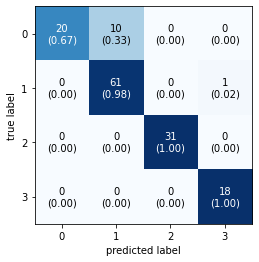

In [30]:
# class_names = ["Islamabad", "Shopian", "Bandipora", "Kupwara"]
conf_mat = confusion_matrix(predictions, ytest)
plot_confusion_matrix(conf_mat, show_normed=True)

In [33]:
class_names, xtest, ytest = get_train_and_test(mfcc24, 0.2, 0.1, purpose="get_labels")

(705, 24, 216, 1)
(705,)


In [39]:
labels = np.unique(class_names)

In [43]:
model24 = keras.models.load_model("./Mfcc 48.h5")
pred_24 = model24.predict_classes(xtest)
# plot_confusion_matrix(pred_24, ytest, labels=labels)


/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: in user code:

    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_6 is incompatible with the layer: expected axis -1 of input shape to have value 10368 but received input with shape (None, 3456)


In [ ]:
plot_confusion_matrix(pred)